# Typosquatted Domain Monitoring

## Introduction
Typosquatting is when a malicious actor purchases a domain that might be easily mistaken (either visually, or through a typo) for an existing domain tied to a reputable organisation. They can then use that domain for various purposes, including impersonating the website hosted at the impersonated domain to harvest credentials or mislead users, or to attack the organisation's reputation via vandalism.

Regarding domains that can look visually similar, there are plenty of characters that can be confused for one another, depending on the font used. Examples of sets of such characters are:
- The numeral one, a capital letter i, the lowercase letter L, and the pipe symbol: "1Il|" (`1Il|`)
- An uppercase letter o and the numeral zero: "O0" (`O0`)
- An uppercase letter s and the numeral 5: "S5" (`S5`)

And so on. These are commonly known about, and the choice of font in can help reduce the danger of mistaking one for the other. More dangerous, perhaps, are "homograph" attacks, where different Unicode codepoints have the same appearance, even under different points. This is to be expected given how languages with different scripts can still share the "same" letters - see the below Venn diagram of Greek, Latin and Cyrillic letters and which letters are common to others:
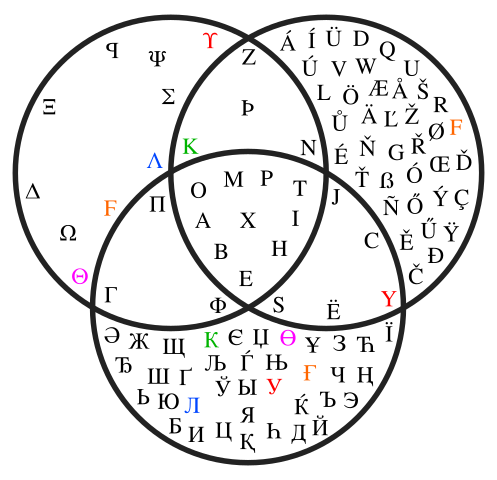

This has led to proof of concepts such as https://www.аррӏе.com/ (where [all the characters are actually in Cyrillic](https://unicode.scarfboy.com/?s=%D0%B0%D1%80%D1%80%D3%8F%D0%B5)). Unicode is aware of the problem, and have a utility to find "confusables" https://util.unicode.org/UnicodeJsps/confusables.jsp (along with the master data file that informs this tool, found here: https://www.unicode.org/Public/security/revision-03/confusablesSummary.txt).

Detecting these sorts of homograph attacks is unfortunately inconsistent, since different browsers behave in different ways upon loading a domain that has homographs. It should be noted that domain names only ever in practice include ASCII characters; to support codepoints beyond that range, an encoding called [Punycode](https://en.wikipedia.org/wiki/Punycode) is used. Some browsers always display URLs as Punycode - some even go a step further, such as Microsoft Edge, and warn users that the domain is probably misleading:
<div>
<img src="screenshot1.png" width="500"/>
</div>

Firefox, on the other hand, renders the URL as-is and does not warn the user at all:

<div>
<img src="screenshot2.png" width="500"/>
</div>

Because of this inconsistency, it's up to those that actually administer these domains to be proactive in reporting typosquatted domains, or even registering them pre-emptively. Once a typosquatted domain is found, it can be reported via sites such as those for [Google's Safe Browsing service](https://safebrowsing.google.com/safebrowsing/report_phish/), [Netcraft's reporting page](https://report.netcraft.com/report), and [NCSC's own website](https://www.ncsc.gov.uk/section/about-this-website/report-scam-website).

## 1. How to monitor for typosquatted domains
My first guess for how to tackle this problem (without looking online) is to have a program that takes a given domain name, and then modifies it with the following two slightly different transforms:
1. Confusable characters
2. Typoable characters (characters that don't look like each other but are close to each other on keyboards, e.g. j and k)

For transformation 1, we can create a dictionary in Python that maps from ASCII keys to a string of "confusables" as defined in the data file above, and then use it to generate new versions of a given domain by iterating over each combination, like so:

In [68]:
import itertools

CONFUSABLES = {"a": "aɑａαа𝐚𝑎𝒂𝒶"} # etc
# The first character of the string is actually a plain ASCII 'a' - this way we can check for mixed ASCII/confusable strings.

def confusables_transform(domain):
    """
    Generator that outputs all possible confusable combinations of the original domain.
    """
    res = []
    for c in domain:
        res.append(CONFUSABLES.get(c, c)) # If we encounter a character not in CONFUSABLES, just use the original
    combinations = itertools.product(*res)
    next(combinations) # Since the first character in each string is going to be the original, first output is just the original domain, so discard
    for i in combinations:
        yield "".join(i)

american_airlines = confusables_transform("aa.com")
for confusable_domains, _ in zip(american_airlines, range(10)): # This is just to limit the output, full output (80 lines) is on commented line below
#for confusable_domains in american_airlines:
    print(confusable_domains)

aɑ.com
aａ.com
aα.com
aа.com
a𝐚.com
a𝑎.com
a𝒂.com
a𝒶.com
ɑa.com
ɑɑ.com


I'm not too sure of this approach already, given that the output would increase exponentially with the length of the string (i.e. $O(a^{n})$).

It's "extensible" in that the second transformation, typoable characters, could be added to each key in the `CONFUSABLES` dictionary as appropriate. So `CONFUSABLES["a"]` could be `"aɑａαа𝐚𝑎𝒂𝒶sqw\zx"`, for example.

I've also realised that this approach misses two different classes of typos:
- Missing characters (e.g. "exmple.com")
- Transposed characters (e.g. "googel.com")

There's probably a better way of searching for these strings. I remember from my time trying to solve the [Cryptopals challenges](https://cryptopals.com/sets/1/challenges/6) that Hamming distance is a way of calculating the difference between two strings. Maybe there's a way of outputting typosquatted domains with a Hamming distance of one or two from the original? I think I should look into commercial and open source products now.

## 2. Commercial products in the space


### Netcraft: https://www.netcraft.com/solutions/by-service/domain-protection/
From the above site:
> Netcraft monitors DNS registrations, zone files and certificate transparency logs for domains and hostnames deceptively similar to your own ... Our insight into the tricks used by criminals—such as substituting lookalike characters, inserting/deleting/re-ordering characters, or adding keywords such as ‘update’, ‘login’ and ‘secure’—feeds into the deceptive domain score that is used to rank the likelihood of misuse. 

This makes me realise that I didn't consider inserting characters or adding keywords. More importantly, however, I've realised that I never considered what to do _after_ I would generate a bunch of lookalike domains... It makes more sense to actually monitor new domain registrations and then see if they're "close" to the domains we want to protect. I'm sure part of Netcraft's value proposition is that they have access to various threat feeds and domain name registration feeds that their systems can monitor, whereas if we rolled our own we'd have to find out which feeds are useful and figure out how to aggregate and search that data - not a simple task.

Netcraft also [automates the takedown of domains and sites](https://www.netcraft.com/solutions/by-service/domain-website-takedown/):
> To conduct a takedown, Netcraft gathers evidence of the cyber attack, and begins to identify the relevant parties providing resources to the attacker. In parallel, Netcraft automatically contacts hosting providers, domain registrars, webmasters and others via email, API, private contact, or otherwise.

Again, having a managed service like this contact registrars and hosts on your behalf eliminates either the toil of doing the manually or the research and implementation time required to automate it in-house.

### Bolster: https://bolster.ai/solutions/typosquatting-protection
Somewhat similar to Netcraft's offering - monitoring of domain registrations and automatic takedowns, but they leverage AI in some interesting ways:
- Reducing the false positive rate. Not sure how (presumably it's trained on a corpus of legitimate and phishing domains), but they seem to be proud of it - "a false positive rate of 1 in 100,000".
- Scanning logos on websites to check if they closely resemble the user's own. Computer vision is a pretty mature branch of AI, so I think this is a really solid application of the technology.

## 3. Open source products in the space
### `dnstwist`: https://github.com/elceef/dnstwist
A Python tool that automatically generates permutations of a given domain, and then does DNS lookups to see which ones are registered. On top of that, it's got a capability to "generate fuzzy hashes of web pages to detect ongoing phishing attacks" - i.e. checking the HTML source of the new domains to see if it closely resembles the site hosted at the original! I wouldn't be surprised if this is something offered by the commercial products, but I didn't see any explicit mention of such a feature on either.

Along with a human readable default format, `dnstwist` can output as CSV or JSON (which would be useful for feeding the results into something like a SIEM, for monitoring and visibility purposes), or it can be used as a library with `import dnstwist`.

The README does provide some caveats to the tool:
> As the length of the input domain increases, the number of variants generated by the algorithms increases significantly ... Thus, this tool generates and checks domains that are very similar to the original one.

This means that some of the things that Netcraft (and presumably Bolster) checks for, such as appending words (e.g. "google-login.com") or related brand names (e.g. "amazon-s3.com") to the domain, are not covered by `dnstwist`. This is a clear disadvantage.
- Edit: I just checked the tool myself against my own domain, and it _does_ add commonly used words to the domain: "connect-denizgenc.co.uk, connectdenizgenc.co.uk, denizgenc-account.co.uk, denizgenc-auth.co.uk..." etc. `dnstwist` still doesn't have any knowledge of associated brands that might be used in phishing campaigns, but it does have a `-d` parameter for supplying custom dictionaries (and includes a default one for [English](https://github.com/elceef/dnstwist/blob/master/dictionaries/english.dict) that can be edited).

Obviously, `dnstwist`'s phishing detection can only work so well, and it does not do automatic takedowns, so that creates two sources of manual intervention (or additional automation infrastructure) to match a managed service like Netcraft or Bolster's.

## openSquat: https://github.com/atenreiro/opensquat
Another Python tool that is quite similar to `dnstwist`. The distinguishing features are:
- Integration with VirusTotal (for subdomain validation) and the Quad9 DNS service (checking for DNS validation)
- Can be used to check for phishing domains (based on the [Phishing Database](https://github.com/mitchellkrogza/Phishing.Database) project)
- Has a confidence level parameter that allows for tuning how much output you want - small output with higher confidence, or more generated domains with a greater chance of false positives.

----

To be honest, I'm not 100% sure what the 2 methods are supposed to be. I'm going to double check by decoding the base64 strings provided in the pdf:

In [71]:
import base64

s1 = "TmV3IGRvbWFpbnMgYXJlIHNjcmFwZWQgZXZlcnkgWCBob3VycyBhbmQgdHJpYWdlZCBhY2NvcmRpbmcgdG8gdGhlaXIgTGV2ZW5zaHRlaW4gZGlzdGFuY2VzIHRvIHRoZSBkb21haW4gdGhleSBhcmUgcG90ZW50aWFsbHkgdHJ5aW5nIHRvIHR5cG9zcXVhdCwgYW1vbmdzdCBvdGhlciB0aGluZ3Mu"
s2 = "R2VuZXJhdGUgdmFyaWFudHMgb2YgYSBtb25pdG9yZWQgZG9tYWluICh2aWEgYWRkaXRpb25zLCBwZXJtdXRhdGlvbnMsIGhvbW9nbHlwaHMsIGJpdHNxdWF0dGluZywgb21pc3Npb25zLCBpbnNlcnRpb25zLCByZXBldGl0aW9ucywgZXRjLi4uKSBhbmQgY2hlY2sgcmVnaXN0cmF0aW9uIHN0YXR1cyBhbmQgbGVnaXRpbWFjeSBvZiB2YXJpYW50Lg=="

print(str(base64.b64decode(s1), "utf-8"))
print(str(base64.b64decode(s2), "utf-8"))

New domains are scraped every X hours and triaged according to their Levenshtein distances to the domain they are potentially trying to typosquat, amongst other things.
Generate variants of a monitored domain (via additions, permutations, homoglyphs, bitsquatting, omissions, insertions, repetitions, etc...) and check registration status and legitimacy of variant.


Right, that makes sense. I've heard of Levenshtein distances before, they're basically Hamming distances but applied on the character level instead of the bit level. The character `d` has a Hamming distance of two to the character `a` (because two bits have to change: `0b1100001` -> `0b1100100`), whereas in Levenshtein it's only got a distance of one, since only a single character is changing.

Researching online I've found that the [Damerau-Levenshtein distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance) is a more suitable metric, since it also counts transposition as a single-distance step. I'll continue referring to this metric as the "Levenshtein distance" for simplicity's sake.

## 4. Pros and cons of the two methods
The first method, domain scraping, is computationally less intensive because given a list of newly registered domains, we can start calculating the distance to our original domains and break out of the processing if it exceeds a limit (e.g. 4). There's no need for generating hundreds, thousands or more permutations, and also no need to regularly do threat hunting to update dictionaries with new strings or words that are common in attacks. The limitation of this approach is that it's very easily sidestepped by attackers, since all that's required is to pad the domain with various characters, increasing the distance with each character added. This technique, when used in combination with subdomains, is also useful because it can push out the actual domain from the user's address bar, especially on mobile devices; I've seen domains that look like `example.com----------------------xyz.net`, which would definitely have a large Levenshtein distance compared to plain old `example.com`.

The second method, where variants are generated, is more flexible in that it can output far more than what can probably be matched based on Levenshtein distance, and dictionaries used for generating variants can be updated and refined for the organisation. However it is proactive in a rather wasteful way - hundreds or thousands of domains have to be generated and checked, and I can imagine caching/saving the list for later (to reduce duplicated processing) can be difficult if we want to update how the underlying code works, or add more entries to the dictionary.

## 5 & 6. Run a report and get results
I'll run a report on my own domain, `denizgenc.co.uk`. [I've got 5 results](https://dnstwister.report/search?ed=64656e697a67656e632e636f2e756b#).

Drom dnstwister's [documentation](https://dnstwister.report/documentation/dnstwister_apis), we can see that they have a public API, which is described as "self-documenting". It can be found at https://dnstwister.report/api/ (prettified for convenience)
```json
{
  "domain_fuzzer_url": "https://dnstwister.report/api/fuzz/{domain_as_hexadecimal}",
  "domain_to_hexadecimal_url": "https://dnstwister.report/api/to_hex/{domain}",
  "google_safe_browsing_url": "https://dnstwister.report/api/safebrowsing/{domain_as_hexadecimal}",
  "has_mx_url": "https://dnstwister.report/api/mx/{domain_as_hexadecimal}",
  "ip_resolution_url": "https://dnstwister.report/api/ip/{domain_as_hexadecimal}",
  "parked_check_url": "https://dnstwister.report/api/parked/{domain_as_hexadecimal}",
  "url": "https://dnstwister.report/api/",
  "whois_url": "https://dnstwister.report/api/whois/{domain_as_hexadecimal}"
}
```

We can use the [`requests`](https://requests.readthedocs.io/en/latest/) library to talk to the fuzzer endpoint. Let's do some exploratory work before we formalise it in a class:

In [82]:
import requests

domain = b"denizgenc.co.uk".hex() # convert to hex
response = requests.get(f"https://dnstwister.report/api/fuzz/{domain}")
#print(response.json()) # Let's see what we get...

# OK, that's a really big output - the key "fuzzy_domains" returns _all_ of the fuzzed domains, not just the ones which are registered.
# Let's try to figure out what sort of keys are available to help us narrow down the results.

keys = set()
for d in response.json().get("fuzzy_domains"):
    keys.update(set(d.keys()))
print(keys)

# It turns out that there's no difference in the keys for a registered domain and one that isn't. We have to make another API call for each domain
# to check if it's registered... That's frustrating.
# This cell takes about ~40 seconds on my machine to execute.
registered = []
for d in response.json().get("fuzzy_domains"):
    ip_response = requests.get(d.get("resolve_ip_url")) # Returns a JSON object with an "ip" key, which is false if not registered
    if ip_response.json().get("ip"):
        registered.append(d.get("domain"))
print(registered)

{'fuzz_url', 'domain_as_hexadecimal', 'has_mx_url', 'resolve_ip_url', 'fuzzer', 'safebrowsing_check_url', 'domain', 'parked_score_url'}
['denizgenc.co.uk', 'denizgenc.com', 'denizgenc.de', 'denizgenc.net', 'deniz.genc.co.uk', 'denizge.nc.co.uk']


Now that we know how to go from a given domain to a list of registered, possibly fake ones, we can refine this into a proper class with fields and methods.

In [ ]:
class DomainGenerator:
    def __init__(self, original_domain):
        self.original_domain = original_domain
        self.hex_domain = hexify(original_domain)
        self.variants = generate_variations()
        self.additional_variants = [] # For any custom ones we want to check for
        self.registered_variants = []

    def hexify(domain):
        """
        Internal method for turning regular string domains into their hex representation, for use in dnstwister API URLs
        """
        return bytes(domain, "utf-8").hex()

    def generate_variants(self):
        """
        Uses the dnstwister API to generate variations of the DomainGenerator's original_domain.
        """
        response = requests.get(f"https://dnstwister.report/api/fuzz/{self.hex_domain}")
        self.variations = response.json().get("fuzzy_domains")[1:] # omit the first result

    def add_custom_variants(self, variant_domain_list):
        """
        Takes a list of strings (that represent variant domains) as input
        """
        # Need to output a dictionary in this format, set "fuzzer" to "Custom" lol
        #{"domain":"example.com",
        #"domain_as_hexadecimal":"6578616d706c652e636f6d",
        #"fuzz_url":"https://dnstwister.report/api/fuzz/6578616d706c652e636f6d",
        #"fuzzer":"Original",
        #"has_mx_url":"https://dnstwister.report/api/mx/6578616d706c652e636f6d",
        #"parked_score_url":"https://dnstwister.report/api/parked/6578616d706c652e636f6d",
        #"resolve_ip_url":"https://dnstwister.report/api/ip/6578616d706c652e636f6d",
        #"safebrowsing_check_url":"https://dnstwister.report/api/safebrowsing/6578616d706c652e636f6d"}

    def check_registered(self):
        for v in self.variants:
            ip_response = requests.get(v.get("resolve_ip_url")).json()
            if ip_response.get("ip"):
                self.registered_variants.append(ip_response)
        